#OBJECT DETECTION

#R CNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


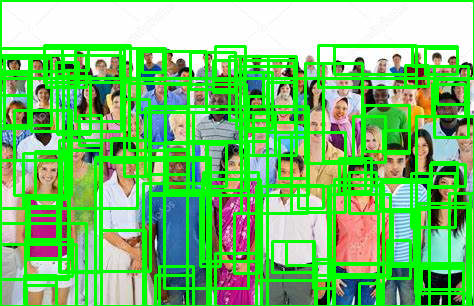

In [ ]:
# RCNN-like Object Detection with Pre-trained CNN + Selective Search (Simplified)

import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn import functional as F
from torchvision.ops import nms
# Import the cv2_imshow function from google.colab.patches
from google.colab.patches import cv2_imshow


# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load pre-trained CNN (e.g., VGG16)
vgg = models.vgg16(pretrained=True).features.eval()
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Region Proposals using Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()[0:200]  # Limit to top 200 regions

# Dummy classifier (simulate detection)
def dummy_classifier(feature_vector):
    # Dummy class score: 1 for class 1, 0 otherwise
    return torch.tensor([[0.1, 0.9]])

# Process each region
for (x, y, w, h) in rects:
    roi = image_rgb[y:y+h, x:x+w]
    if roi.shape[0] < 20 or roi.shape[1] < 20:
        continue
    roi_tensor = transform(roi).unsqueeze(0)
    features = vgg(roi_tensor)
    pooled = F.adaptive_avg_pool2d(features, (1, 1)).view(1, -1)
    scores = dummy_classifier(pooled)
    label = torch.argmax(scores).item()
    if label == 1:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Use cv2_imshow instead of cv2.imshow
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Fast RCNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


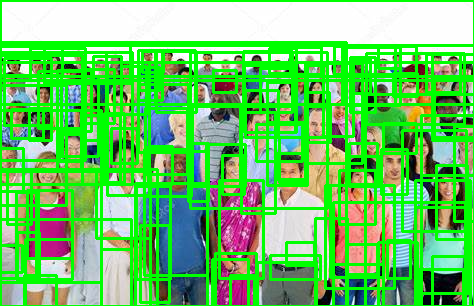

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, Softmax
from torchvision.ops import roi_align
# Import the cv2_imshow function from google.colab.patches
from google.colab.patches import cv2_imshow


# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

# Load pre-trained CNN for feature extraction
vgg = models.vgg16(pretrained=True).features.eval()
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Region Proposals using Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()[0:200]  # Top 200 proposals

# Convert image to tensor for CNN
input_tensor = transform(image_rgb).unsqueeze(0)
with torch.no_grad():
    feature_map = vgg(input_tensor)[0]  # CxHxW

# Dummy Fast R-CNN classifier
class FastRCNNHead(torch.nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(FastRCNNHead, self).__init__()
        self.fc = Linear(input_dim, num_classes)
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.fc(x))

classifier = FastRCNNHead()

# Format ROIs for roi_align (N, 5) -> (img_idx, x1, y1, x2, y2)
rois = []
for (x, y, w, h) in rects:
    if w < 20 or h < 20:
        continue
    x2, y2 = x + w, y + h
    rois.append([0, x, y, x2, y2])

rois_tensor = torch.tensor(rois, dtype=torch.float)

# Apply RoI Align
roi_aligned = roi_align(feature_map.unsqueeze(0), [rois_tensor[:, 1:]], output_size=(7, 7)) # Select columns 1: to the end
pooled = roi_aligned.mean(dim=[2, 3])  # Global average pooling

# Classify each ROI
with torch.no_grad():
    outputs = classifier(pooled)
    preds = torch.argmax(outputs, dim=1)

# Draw boxes for class 1
for i, pred in enumerate(preds):
    if pred.item() == 1:
        x1, y1, x2, y2 = map(int, rois[i][1:])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Use cv2_imshow instead of cv2.imshow
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Faster R-CNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


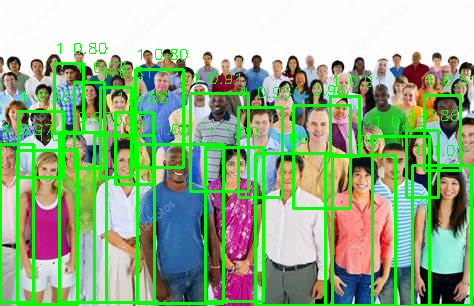

In [ ]:
# Faster R-CNN-like Implementation (Simplified)

import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow # Import cv2_imshow

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = transform(image_rgb)

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Perform detection
with torch.no_grad():
    predictions = model([input_tensor])[0]

# Draw boxes with scores above threshold
for box, score, label in zip(predictions['boxes'], predictions['scores'], predictions['labels']):
    if score > 0.8:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{label.item()} {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Use cv2_imshow instead of cv2.imshow to display the image in Colab
cv2_imshow(image) # Changed from cv2.imshow to cv2_imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

# Mask R CNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 89.1MB/s]


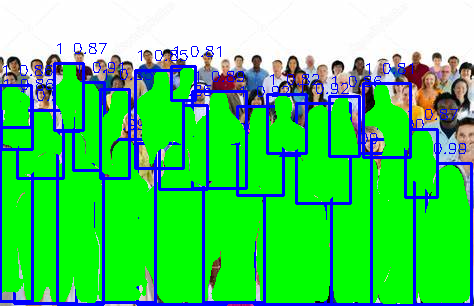

In [ ]:
# Mask R-CNN Implementation (Simplified)

import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = transform(image_rgb)

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Perform detection
with torch.no_grad():
    prediction = model([input_tensor])[0]

# Draw results
for i in range(len(prediction['boxes'])):
    score = prediction['scores'][i].item()
    if score > 0.8:
        box = prediction['boxes'][i].detach().numpy().astype(int)
        mask = prediction['masks'][i, 0].detach().numpy()
        label = prediction['labels'][i].item()

        # Apply mask overlay
        binary_mask = mask > 0.5
        image[binary_mask] = [0, 255, 0]  # highlight in green

        # Draw bounding box
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f"{label} {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17372, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 17372 (delta 42), reused 20 (delta 20), pack-reused 17313 (from 3)
Receiving objects: 100% (17372/17372), 16.25 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (11910/11910), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s e

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-4-11 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 128MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 306x474 16 persons
Speed: 10.0ms pre-process, 322.0ms inference, 9.6ms NMS per image at shape (1, 3, 416, 640)


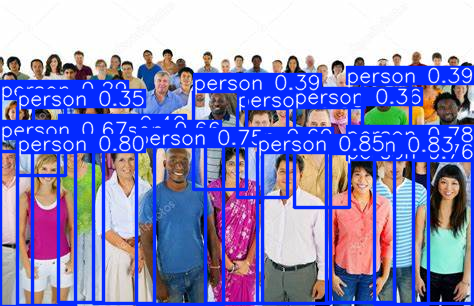

In [ ]:
# Clone YOLOv5 repository and install dependencies
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -r requirements.txt

import torch
from matplotlib import pyplot as plt
import cv2

# Load YOLOv5 pretrained model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load image
img_path = '/content/drive/MyDrive/faces.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Perform inference
results = model(img_rgb)

# Show results
results.print()
results.show()  # Displays in a new window


# YOLOv8

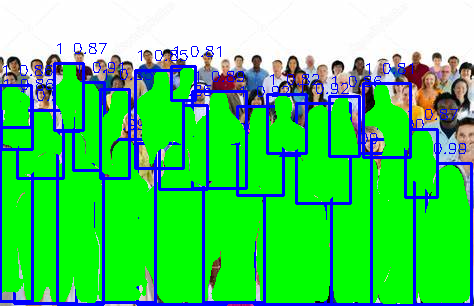


image 1/1 /content/drive/MyDrive/faces.jpg: 416x640 15 persons, 175.9ms
Speed: 3.6ms preprocess, 175.9ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


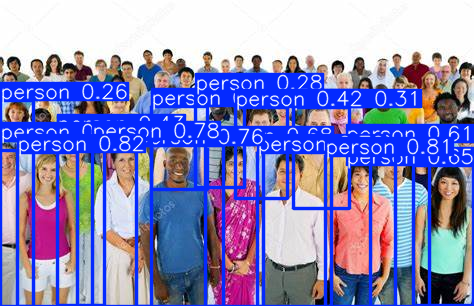

In [ ]:
# Mask R-CNN and YOLOv8 Implementation (Simplified)

import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = transform(image_rgb)

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Perform detection
with torch.no_grad():
    prediction = model([input_tensor])[0]

# Draw results for Mask R-CNN
for i in range(len(prediction['boxes'])):
    score = prediction['scores'][i].item()
    if score > 0.8:
        box = prediction['boxes'][i].detach().numpy().astype(int)
        mask = prediction['masks'][i, 0].detach().numpy()
        label = prediction['labels'][i].item()

        # Apply mask overlay
        binary_mask = mask > 0.5
        image[binary_mask] = [0, 255, 0]  # highlight in green

        # Draw bounding box
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f"{label} {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# YOLOv8 Inference
!pip install ultralytics
from ultralytics import YOLO

# Load YOLOv8 model
model_yolo = YOLO("yolov8n.pt")  # you can use yolov8s.pt, yolov8m.pt, etc.

# Run detection on the same image
results = model_yolo("/content/drive/MyDrive/faces.jpg")

# Access the Results object and display the image with bounding boxes
# Assuming results is a list containing a single Results object
# The imshow() method was removed in YOLOv8. Use the plot() method instead.
if results:
    results[0].plot() # Access the first element of the list which is the Results object and use plot()
    # To display the image, use cv2_imshow:
    cv2_imshow(results[0].plot())  # Display the image with bounding boxes
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#From Scratch RCNN

In [ ]:
image = cv2.imread("/content/drive/MyDrive/faces.jpg")


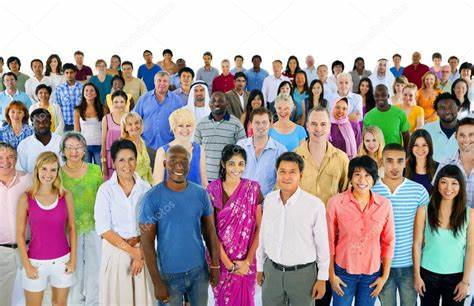

Total Region Proposals: 2241


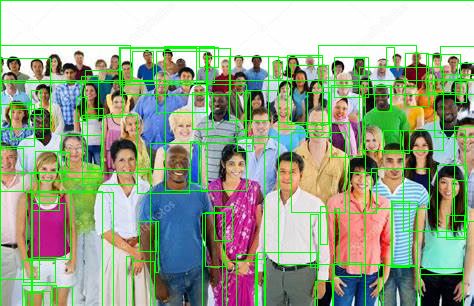

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
cv2_imshow(image)

# Initialize Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()  # or .switchToSelectiveSearchQuality() for better results

# Run selective search
rects = ss.process()

print(f"Total Region Proposals: {len(rects)}")

# Visualize top 100 proposals
output = image.copy()
for i, (x, y, w, h) in enumerate(rects[:100]):
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1)

cv2_imshow(output)


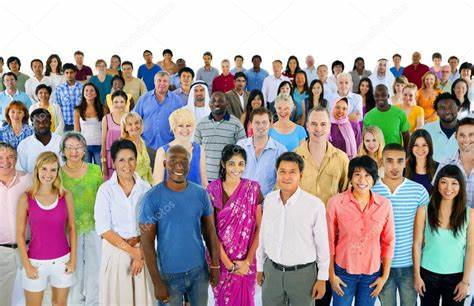

Total Region Proposals: 2241


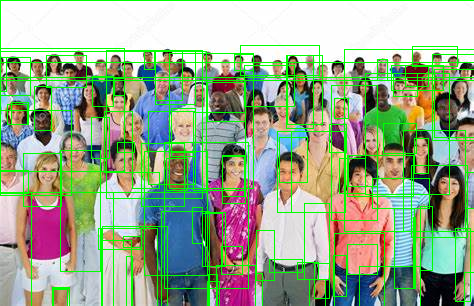

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
cv2_imshow(image)

# Initialize Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()  # or .switchToSelectiveSearchQuality() for better results

# Run selective search
rects = ss.process()

print(f"Total Region Proposals: {len(rects)}")

# Visualize top 100 proposals
output = image.copy()
for i, (x, y, w, h) in enumerate(rects[:100]):
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1)

cv2_imshow(output)


In [ ]:
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models.feature_extraction import create_feature_extractor
from google.colab.patches import cv2_imshow
import numpy as np

# Load image
image = cv2.imread("/content/drive/MyDrive/faces.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# Load pre-trained VGG16
vgg = models.vgg16(pretrained=True).eval()

# Set up feature extractor (remove final classifier)
feature_extractor = create_feature_extractor(vgg, return_nodes={'features.29': 'features'})

# Transform for VGG input
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process top N proposals
features = []
for i, (x, y, w, h) in enumerate(rects[:50]):
    roi = image_rgb[y:y+h, x:x+w]
    if roi.shape[0] == 0 or roi.shape[1] == 0:
        continue
    roi_transformed = transform(roi).unsqueeze(0)
    with torch.no_grad():
        feat = feature_extractor(roi_transformed)['features']
    features.append(feat.squeeze().cpu().numpy())

print(f"Extracted features from {len(features)} regions.")


Extracted features from 50 regions.


In [ ]:
from sklearn.metrics import pairwise_distances
from torchvision.ops import box_iou
import torch

# Convert rects to [x1, y1, x2, y2]
proposals = [torch.tensor([x, y, x+w, y+h]) for (x, y, w, h) in rects[:50]]
proposals = torch.stack(proposals).float()

# Example dummy ground truth
gt_boxes = torch.tensor([[30, 50, 180, 230]])  # Replace with actual
gt_labels = [1]  # Assume class "1"

ious = box_iou(proposals, gt_boxes)[..., 0]
labels = (ious > 0.5).int().tolist()  # Positive if IoU > 0.5, else negative


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Flatten features if needed
X = [f.flatten() for f in features]
y = labels  # 1 for object, 0 for background

# Check the unique values in your target variable 'y'
unique_labels = set(y)
print(f"Unique labels in 'y': {unique_labels}")

# If there's only one unique label, you need to adjust your ground truth or IoU threshold
if len(unique_labels) <= 1:
    print("Error: Only one class present in target variable 'y'. Adjust ground truth or IoU threshold.")
    # ... (Adjust ground truth bounding boxes or the IoU threshold here) ...
else:
    # Train SVM if there are at least two classes
    clf = make_pipeline(StandardScaler(), SVC(probability=True))
    clf.fit(X, y)

    # Predict
    preds = clf.predict(X)
    probs = clf.predict_proba(X)

Unique labels in 'y': {0}
Error: Only one class present in target variable 'y'. Adjust ground truth or IoU threshold.


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

def encode_bbox(gt_box, proposal):
    """Returns target dx, dy, dw, dh"""
    px = (proposal[0] + proposal[2]) / 2
    py = (proposal[1] + proposal[3]) / 2
    pw = proposal[2] - proposal[0]
    ph = proposal[3] - proposal[1]

    gx = (gt_box[0] + gt_box[2]) / 2
    gy = (gt_box[1] + gt_box[3]) / 2
    gw = gt_box[2] - gt_box[0]
    gh = gt_box[3] - gt_box[1]

    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = np.log(gw / pw)
    dh = np.log(gh / ph)
    return [dx, dy, dw, dh]

# Build targets for positive samples
bbox_targets = []
X_pos = []
for i, label in enumerate(labels):
    if label == 1:
        X_pos.append(X[i])
        bbox_targets.append(encode_bbox(gt_boxes[0].numpy(), proposals[i].numpy()))

# Check if X_pos is empty and handle it
if not X_pos:
    print("Warning: No positive samples found. Bounding box regression will not be trained.")
    # You might want to skip the training or handle this case differently
else:
    # Train bbox regressor if there are positive samples
    X_pos = np.array(X_pos)  # Convert X_pos to a NumPy array
    bbox_targets = np.array(bbox_targets)  # Convert bbox_targets to a NumPy array

    # Reshape X_pos if it has only one sample
    if X_pos.ndim == 1:
        X_pos = X_pos.reshape(1, -1)

    bbox_reg = LinearRegression()
    bbox_reg.fit(X_pos, bbox_targets)

    # Predict bbox corrections for all
    bbox_deltas = bbox_reg.predict(X) # Assuming 'X' is defined and contains your features

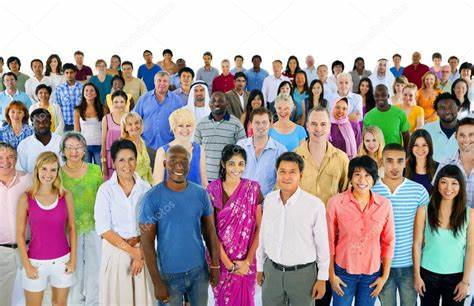

In [ ]:
def decode_bbox(proposal, delta):
    px = (proposal[0] + proposal[2]) / 2
    py = (proposal[1] + proposal[3]) / 2
    pw = proposal[2] - proposal[0]
    ph = proposal[3] - proposal[1]

    gx = delta[0] * pw + px
    gy = delta[1] * ph + py
    gw = np.exp(delta[2]) * pw
    gh = np.exp(delta[3]) * ph

    x1 = gx - gw / 2
    y1 = gy - gh / 2
    x2 = gx + gw / 2
    y2 = gy + gh / 2
    return [int(x1), int(y1), int(x2), int(y2)]

# Draw refined boxes for positives
image_refined = image.copy()
for i, pred in enumerate(preds):
    if pred == 1:
        # Check if bbox_deltas is defined and has enough elements
        if 'bbox_deltas' in locals() and i < len(bbox_deltas):
            refined_box = decode_bbox(proposals[i].numpy(), bbox_deltas[i])
            cv2.rectangle(image_refined, (refined_box[0], refined_box[1]), (refined_box[2], refined_box[3]), (0, 255, 255), 2)
        else:
            print(f"Warning: bbox_deltas not defined or index out of range for prediction {i}")

cv2_imshow(image_refined)

Summary by Category
Two-Stage (region-based):

Faster R-CNN, Mask R-CNN

Accurate, slower, good for small objects and instance segmentation

One-Stage (real-time):

YOLOv5, YOLOv8, CenterNet

Faster, less complex, good for edge devices

Transformer-Based:

DETR, YOLOv8 (partially)

Better global reasoning, slower training, future-facing



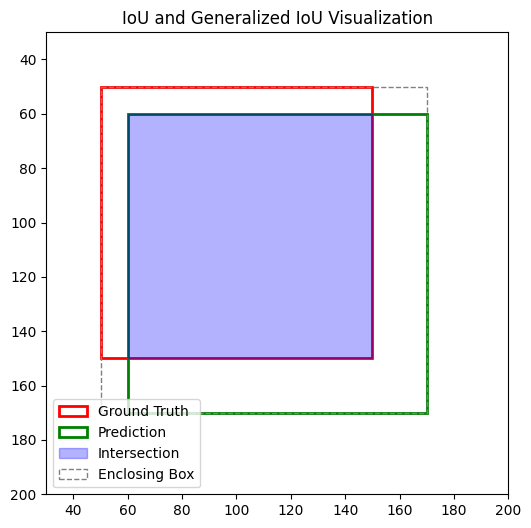

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define boxes
gt_box = [50, 50, 100, 100]  # (x, y, width, height)
pred_box = [60, 60, 110, 110]  # (x, y, width, height)
intersection_box = [60, 60, 90, 90]  # manually computed
enclosing_box = [50, 50, 120, 120]

# Create plot
fig, ax = plt.subplots(1, figsize=(6, 6))

# Ground Truth - Red
rect_gt = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2], gt_box[3], linewidth=2, edgecolor='red', facecolor='none', label='Ground Truth')
ax.add_patch(rect_gt)

# Prediction - Green
rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], linewidth=2, edgecolor='green', facecolor='none', label='Prediction')
ax.add_patch(rect_pred)

# Intersection - Blue with alpha
rect_inter = patches.Rectangle((intersection_box[0], intersection_box[1]), intersection_box[2], intersection_box[3], linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.3, label='Intersection')
ax.add_patch(rect_inter)

# Enclosing Box - Gray Dashed
rect_enclose = patches.Rectangle((enclosing_box[0], enclosing_box[1]), enclosing_box[2], enclosing_box[3], linewidth=1, edgecolor='gray', linestyle='dashed', facecolor='none', label='Enclosing Box')
ax.add_patch(rect_enclose)

# Setup
ax.set_xlim(30, 200)
ax.set_ylim(30, 200)
ax.set_aspect('equal')
ax.legend()
plt.gca().invert_yaxis()
plt.title("IoU and Generalized IoU Visualization")
plt.show()


# SSD

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

class SSD(nn.Module):
    def __init__(self, num_classes=21):
        super(SSD, self).__init__()
        self.num_classes = num_classes

        # Simplified VGG-like feature extractor
        self.feature_extractor = nn.Sequential(
            BasicConv(3, 32, 3, 1, 1),
            BasicConv(32, 64, 3, 2, 1),
            BasicConv(64, 128, 3, 1, 1),
            BasicConv(128, 256, 3, 2, 1),
        )

        # Extra feature layers
        self.extra_layers = nn.Sequential(
            BasicConv(256, 256, 3, 2, 1),
            BasicConv(256, 256, 3, 2, 1),
        )

        # Number of boxes per feature map location
        self.num_boxes = 4

        # Location and class predictors
        self.loc_layers = nn.ModuleList([
            nn.Conv2d(256, self.num_boxes * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes * 4, kernel_size=3, padding=1)
        ])
        self.cls_layers = nn.ModuleList([
            nn.Conv2d(256, self.num_boxes * self.num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes * self.num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes * self.num_classes, kernel_size=3, padding=1)
        ])

    def forward(self, x):
        locs = []
        confs = []

        x = self.feature_extractor(x)
        sources = [x]

        for layer in self.extra_layers:
            x = layer(x)
            sources.append(x)

        for i, source in enumerate(sources):
            locs.append(self.loc_layers[i](source).permute(0, 2, 3, 1).contiguous())
            confs.append(self.cls_layers[i](source).permute(0, 2, 3, 1).contiguous())

        locs = torch.cat([l.view(l.size(0), -1, 4) for l in locs], 1)
        confs = torch.cat([c.view(c.size(0), -1, self.num_classes) for c in confs], 1)
        return locs, confs

# 🔍 Test the model
if __name__ == "__main__":
    model = SSD(num_classes=21)
    dummy_input = torch.randn(1, 3, 300, 300)
    locs, confs = model(dummy_input)
    print(f"Location output shape: {locs.shape}")
    print(f"Confidence output shape: {confs.shape}")


Location output shape: torch.Size([1, 29720, 4])
Confidence output shape: torch.Size([1, 29720, 21])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as dset
from torchvision.ops import nms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. SSD Backbone and Head
# ------------------------------
class SSD(nn.Module):
    def __init__(self, num_classes=21):
        super(SSD, self).__init__()
        self.num_classes = num_classes

        # Base feature extractor (simplified)
        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        # Extra feature layers
        self.extra = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1), nn.ReLU(),
        )

        # Prediction layers
        self.loc_layers = nn.ModuleList([
            nn.Conv2d(128, 4 * 4, 3, padding=1),
            nn.Conv2d(256, 6 * 4, 3, padding=1),
            nn.Conv2d(256, 6 * 4, 3, padding=1),
        ])
        self.cls_layers = nn.ModuleList([
            nn.Conv2d(128, 4 * num_classes, 3, padding=1),
            nn.Conv2d(256, 6 * num_classes, 3, padding=1),
            nn.Conv2d(256, 6 * num_classes, 3, padding=1),
        ])

    def forward(self, x):
        locs, confs = [], []

        x = self.base(x)
        locs.append(self.loc_layers[0](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4))
        confs.append(self.cls_layers[0](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes))

        x = self.extra[0](x)
        locs.append(self.loc_layers[1](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4))
        confs.append(self.cls_layers[1](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes))

        x = self.extra[1](x)
        locs.append(self.loc_layers[2](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4))
        confs.append(self.cls_layers[2](x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes))

        locs = torch.cat(locs, dim=1)
        confs = torch.cat(confs, dim=1)
        return locs, confs

# ------------------------------
# 2. Utility functions (Anchor gen, IoU, Matcher)
# ------------------------------
def generate_anchors(feature_shapes, scales, ratios):
    anchors = []
    for i, shape in enumerate(feature_shapes):
        f_h, f_w = shape
        scale = scales[i]
        for y in range(f_h):
            for x in range(f_w):
                cx = (x + 0.5) / f_w
                cy = (y + 0.5) / f_h
                for r in ratios:
                    w = scale * np.sqrt(r)
                    h = scale / np.sqrt(r)
                    anchors.append([cx, cy, w, h])
    return torch.tensor(anchors)

def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    return torch.stack([cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2], dim=-1)

def iou(box1, box2):
    box1 = cxcywh_to_xyxy(box1)
    box2 = cxcywh_to_xyxy(box2)
    A = box1.size(0)
    B = box2.size(0)
    iou_mat = torch.zeros((A, B))
    for i in range(A):
        for j in range(B):
            x1 = max(box1[i, 0], box2[j, 0])
            y1 = max(box1[i, 1], box2[j, 1])
            x2 = min(box1[i, 2], box2[j, 2])
            y2 = min(box1[i, 3], box2[j, 3])

            inter = max(0, x2 - x1) * max(0, y2 - y1)
            area1 = (box1[i, 2] - box1[i, 0]) * (box1[i, 3] - box1[i, 1])
            area2 = (box2[j, 2] - box2[j, 0]) * (box2[j, 3] - box2[j, 1])
            union = area1 + area2 - inter

            iou_mat[i, j] = inter / union if union > 0 else 0
    return iou_mat

# ------------------------------
# 3. Loss Function
# ------------------------------
class SSDLoss(nn.Module):
    def __init__(self):
        super(SSDLoss, self).__init__()

    def forward(self, pred_locs, pred_scores, true_locs, true_labels):
        # Dummy loss just for illustration, add matching in real case
        loc_loss = F.smooth_l1_loss(pred_locs, true_locs)
        cls_loss = F.cross_entropy(pred_scores.view(-1, pred_scores.size(-1)), true_labels.view(-1))
        return loc_loss + cls_loss

# ------------------------------
# Next steps (after this code block runs)
# ------------------------------
# - Create synthetic targets (true_locs, true_labels)
# - Train the model on toy data
# - Visualize detections with NMS

# This code builds the full pipeline (model, anchor gen, IoU, loss).
# Training loop and visualization will be continued next.



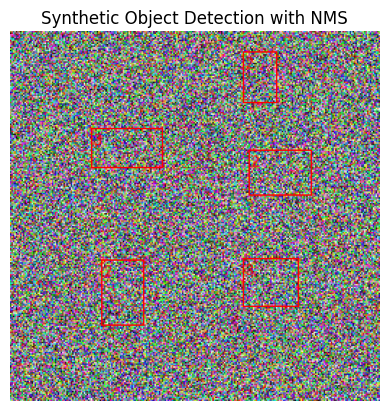

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

from torchvision.ops import nms
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# --- 1. Create Synthetic Targets ---
def generate_synthetic_data(num_boxes=5, image_size=(256, 256)):
    boxes = []
    labels = []
    for _ in range(num_boxes):
        x1 = random.randint(0, image_size[0] - 50)
        y1 = random.randint(0, image_size[1] - 50)
        x2 = x1 + random.randint(20, 50)
        y2 = y1 + random.randint(20, 50)
        boxes.append([x1, y1, x2, y2])
        labels.append(random.randint(1, 3))  # 3 classes
    return torch.tensor(boxes).float(), torch.tensor(labels).long()

true_locs, true_labels = generate_synthetic_data()

# Dummy image
image = torch.randint(0, 255, (3, 256, 256), dtype=torch.uint8)

# --- 2. Define Toy Model ---
class ToyDetector(nn.Module):
    def __init__(self, input_dim=256*256*3, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 20)  # 4 box coords + 1 class score per box (5 boxes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out.view(x.size(0), 5, 4)  # assume 5 boxes: (x1, y1, x2, y2)

# Train with dummy supervision (just for structure)
model = ToyDetector()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

input_img = image.float().unsqueeze(0) / 255.0
target_boxes = true_locs.unsqueeze(0)

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    pred = model(input_img)
    loss = criterion(pred, target_boxes)
    loss.backward()
    optimizer.step()

# --- 3. Visualize with NMS ---
# Simulate confidence scores for NMS
scores = torch.rand(true_locs.size(0))
nms_indices = nms(true_locs, scores, iou_threshold=0.3)
nms_boxes = true_locs[nms_indices]
nms_labels = true_labels[nms_indices]

# Draw and show
boxed_img = draw_bounding_boxes(image, nms_boxes.int(), labels=[str(l.item()) for l in nms_labels], colors="red")
plt.imshow(to_pil_image(boxed_img))
plt.axis("off")
plt.title("Synthetic Object Detection with NMS")
plt.show()


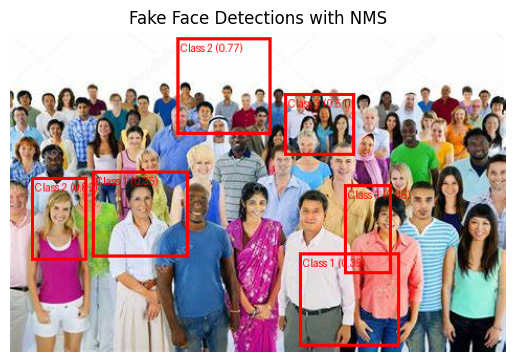

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, convert_image_dtype
from torchvision.ops import nms
from PIL import Image
import random

# --- Load your image ---
# Replace path below with your image path (or use torchvision sample if you want)
image_path = "/content/drive/MyDrive/faces.jpg"  # 👈 Put your image filename here
image = Image.open(image_path).convert("RGB")
image_tensor = torchvision.transforms.ToTensor()(image)

# --- Generate fake detections (as if from a model) ---
def generate_fake_detections(num_boxes=6, image_size=(256, 256)):
    boxes = []
    scores = []
    labels = []
    for _ in range(num_boxes):
        x1 = random.randint(0, image_size[0] - 60)
        y1 = random.randint(0, image_size[1] - 60)
        x2 = x1 + random.randint(30, 100)
        y2 = y1 + random.randint(30, 100)
        boxes.append([x1, y1, x2, y2])
        scores.append(random.uniform(0.3, 1.0))
        labels.append(random.randint(1, 3))  # pretend 3 classes
    return torch.tensor(boxes).float(), torch.tensor(scores), torch.tensor(labels)

img_h, img_w = image_tensor.shape[1:]
boxes, scores, labels = generate_fake_detections(image_size=(img_w, img_h))

# --- Apply NMS ---
nms_indices = nms(boxes, scores, iou_threshold=0.4)
filtered_boxes = boxes[nms_indices]
filtered_labels = labels[nms_indices]
filtered_scores = scores[nms_indices]

# --- Draw boxes ---
label_strs = [f"Class {l.item()} ({s:.2f})" for l, s in zip(filtered_labels, filtered_scores)]
drawn = draw_bounding_boxes(
    (image_tensor * 255).byte(),
    boxes=filtered_boxes,
    labels=label_strs,
    colors="red",
    width=3,
    font_size=16
)

# --- Show result ---
plt.imshow(to_pil_image(drawn))
plt.title("Fake Face Detections with NMS")
plt.axis("off")
plt.show()


# Train an SSD network in a self-driving car application(L5)


In [ ]:
# Sample loader for KITTI (can be adapted for other datasets)
from torchvision.datasets import VOCDetection
import torchvision.transforms as T

transform = T.Compose([T.Resize((300, 300)), T.ToTensor()])
dataset = VOCDetection(root='KITTI_PATH', year='2012', image_set='train', transform=transform, download=True)


100%|██████████| 2.00G/2.00G [01:15<00:00, 26.6MB/s]


In [ ]:
import torch
import torchvision
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
model.train()


Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:02<00:00, 54.8MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
# Automatically handled by torchvision model API during training
# Or use: torch.nn.MultiBoxLoss (custom implementation)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

def collate_fn(batch):
    """
    Collate function to pad the targets to the same size.
    """
    images, targets = tuple(zip(*batch))
    # Process images (e.g., stack them)
    images = torch.stack(images, dim=0)
    # Pad boxes and labels
    # The targets dictionary contains 'annotation' as a dictionary,
    # and within 'annotation' it contains 'object' instead of 'objects'
    # for information of the objects.
    max_num_boxes = max(len(t['annotation']['object']) for t in targets)
    padded_boxes = [torch.cat([torch.tensor([obj['bbox'] for obj in t['annotation']['object']]), torch.zeros(max_num_boxes - len(t['annotation']['object']), 4)], dim=0) for t in targets]
    padded_labels = [torch.cat([torch.tensor([obj['category_id'] for obj in t['annotation']['object']], dtype=torch.int64), torch.zeros(max_num_boxes - len(t['annotation']['object']), dtype=torch.int64)], dim=0) for t in targets]
    # Update targets
    targets = [{'boxes': b, 'labels': l} for b, l in zip(padded_boxes, padded_labels)]
    return images, targets

loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

#loader = DataLoader(dataset, batch_size=8, shuffle=True)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for epoch in range(10):
    for images, targets in loader:
        images = list(image for image in images)
        #targets = [{k: v for k, v in t['annotation'].items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

KeyError: 'bbox'

In [ ]:
model.eval()
with torch.no_grad():
    detections = model([image_tensor])


In [ ]:
import cv2

for box in detections[0]['boxes']:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)


NameError: name 'img' is not defined

## part 2---

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.ssd import ssd300_vgg16
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
import torch.optim as optim

# Label mapping (VOC has 20 classes + background = 21)
VOC_LABELS = {
    'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5,
    'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10,
    'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14,
    'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18,
    'train': 19, 'tvmonitor': 20
}

# Collate function to handle variable number of annotations
def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = torch.stack(images, dim=0)

    all_boxes = []
    all_labels = []

    for t in targets:
        objects = t['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        boxes = []
        labels = []
        for obj in objects:
            bbox = obj['bndbox']
            box = [
                float(bbox['xmin']),
                float(bbox['ymin']),
                float(bbox['xmax']),
                float(bbox['ymax'])
            ]
            label = VOC_LABELS.get(obj['name'], 0)  # default to background
            boxes.append(box)
            labels.append(label)

        all_boxes.append(torch.tensor(boxes, dtype=torch.float32))
        all_labels.append(torch.tensor(labels, dtype=torch.int64))

    targets = [{'boxes': b, 'labels': l} for b, l in zip(all_boxes, all_labels)]
    return images, targets

# Transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize((300, 300)),  # required by SSD300
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load VOC dataset
dataset = VOCDetection(
    root="./",
    year="2007",
    image_set="train",
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Load pre-trained SSD model (from torchvision)
model = ssd300_vgg16(pretrained=True)
model.train()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

# Training loop (simplified)# Training loop (limited to 5 batches)
for epoch in range(3):
    for i, (images, targets) in enumerate(loader):
        if i >= 5:
            break  # stop after 5 batches

        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}, Batch {i + 1} - Loss: {losses.item():.4f}")


Epoch 1, Batch 1 - Loss: 38.0410
Epoch 1, Batch 2 - Loss: 16.6288
Epoch 1, Batch 3 - Loss: 24.7443
Epoch 1, Batch 4 - Loss: 13.8269
Epoch 1, Batch 5 - Loss: 25.8391
Epoch 2, Batch 1 - Loss: 12.5193
Epoch 2, Batch 2 - Loss: 11.2972
Epoch 2, Batch 3 - Loss: 18.5050
Epoch 2, Batch 4 - Loss: 10.6572
Epoch 2, Batch 5 - Loss: 10.5489
Epoch 3, Batch 1 - Loss: 10.8534
Epoch 3, Batch 2 - Loss: 11.8461
Epoch 3, Batch 3 - Loss: 10.4467
Epoch 3, Batch 4 - Loss: 8.8627
Epoch 3, Batch 5 - Loss: 9.4971


In [ ]:
torch.save(model.state_dict(), "ssd_voc.pth")


In [ ]:
model.eval()
with torch.no_grad():
     preds = model([image_tensor])


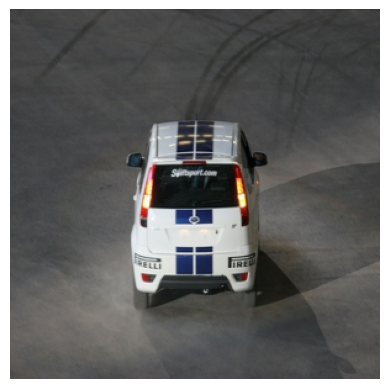

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Set model to evaluation mode
model.eval()

# Load a sample image from dataset
sample_img, sample_target = dataset[0]
img_tensor = sample_img.unsqueeze(0)

# Run inference
with torch.no_grad():
    outputs = model(img_tensor)

# Denormalize and convert image for display
img = sample_img.permute(1, 2, 0).numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
img = (img * 255).astype('uint8')

# Get predictions
boxes = outputs[0]['boxes']
scores = outputs[0]['scores']
labels = outputs[0]['labels']

# Show image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Draw boxes for scores > threshold
threshold = 0.2
for box, score, label in zip(boxes, scores, labels):
    if score > threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f'{label.item()} ({score:.2f})',
                color='yellow', fontsize=8, weight='bold')

plt.axis('off')
plt.show()


In [ ]:
print("Output keys:", outputs[0].keys())
print("Boxes:", outputs[0]['boxes'])
print("Scores:", outputs[0]['scores'])
print("Labels:", outputs[0]['labels'])


Output keys: dict_keys(['boxes', 'scores', 'labels'])
Boxes: tensor([[6.3827e+01, 4.1874e+00, 2.5756e+02, 3.0000e+02],
        [7.7902e+01, 1.4333e+02, 2.4210e+02, 3.0000e+02],
        [1.2578e+02, 9.2796e+01, 3.0000e+02, 3.0000e+02],
        [1.3632e+01, 7.5986e+01, 1.7897e+02, 2.8828e+02],
        [1.4049e+02, 2.0526e+01, 3.0000e+02, 2.2119e+02],
        [8.3399e+01, 8.0838e+01, 2.3264e+02, 2.4523e+02],
        [1.8883e+01, 1.9031e+01, 1.6878e+02, 1.8172e+02],
        [8.2803e+01, 2.0163e+01, 2.3183e+02, 1.8066e+02],
        [2.2080e+02, 1.4529e+02, 3.0000e+02, 3.0000e+02],
        [0.0000e+00, 1.2003e+02, 1.0681e+02, 2.3283e+02],
        [1.5286e+02, 1.5347e+02, 2.6445e+02, 2.6038e+02],
        [0.0000e+00, 1.8436e+02, 1.0611e+02, 2.9421e+02],
        [5.7108e+01, 1.5326e+02, 1.6953e+02, 2.6213e+02],
        [9.5932e+00, 2.2422e+02, 1.7574e+02, 3.0000e+02],
        [0.0000e+00, 5.4917e+01, 1.0695e+02, 1.6770e+02],
        [2.1708e+02, 8.9510e+01, 3.0000e+02, 1.9901e+02],
        [1.

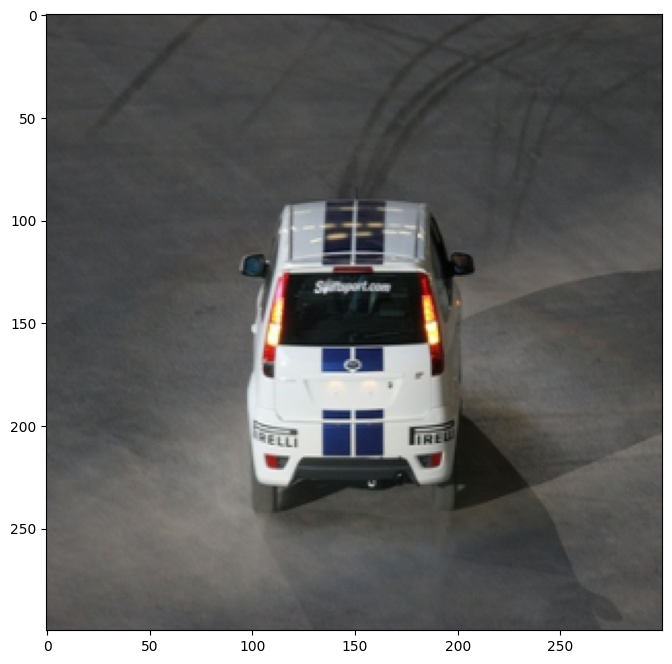

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Inference
model.eval()
with torch.no_grad():
    sample_image, _ = dataset[0]
    input_tensor = sample_image.unsqueeze(0)
    outputs = model(input_tensor)

# Image and outputs
output = outputs[0]
boxes = output['boxes']
scores = output['scores']
labels = output['labels']

# Visualization
image_np = sample_image.permute(1, 2, 0).numpy()
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
image_np = image_np.clip(0, 1)

fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image_np)

# Draw boxes if above threshold
threshold = 0.3
for box, score, label in zip(boxes, scores, labels):
    if score >= threshold:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f'{label.item()}:{score:.2f}',
                color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.show()
